## Agent-Based Model for Trust

In [1]:
import pandas as pd
import random

### The strategies

In [2]:
GOOD = "0"
EVIL = "1"

class Strategy:
  def interact(self):
    return None

# the good guys
class Cooperator(Strategy):
  def interact(self):
    return GOOD

# the bad guys
class Criminal(Strategy):
  def interact(self):
    return EVIL

# the good guys who get a grudge and become bad
class Hater(Strategy):
  def interact(self):
    if (self.agent.grudge_time > 0): return EVIL
    
    bad_experiences = self.agent.history.count(EVIL)
    grim_trigger = bad_experiences > 5
    if grim_trigger:
      self.agent.grudge_time = 200
      self.agent.reset()
    return GOOD

# the bad guys who are imprisoned and become good
class Prisoner(Strategy):
  def interact(self):
    if (self.agent.prison_time > 0): return GOOD

    bad_actions = self.agent.actions.count(EVIL)
    prison_trigger = bad_actions > 5
    if prison_trigger:
      self.agent.prison_time = 4000
      self.agent.reset()
    return EVIL

### The agents

In [3]:
class Agent: 
  def __init__(self, s):
    self.actions = []
    self.history = []
    self.strategy = s
    self.strategy.agent = self
    self.prison_time = 0
    self.grudge_time = 0

  def timestep(self):
    # decrease negative emotions for agents
    if (self.grudge_time > 0): self.grudge_time -= 1
    
    # decrease prison time for agents
    if (self.prison_time > 0): self.prison_time -= 1

  def reset(self):
    # fresh start after a prison time or a grudge
    self.actions = []
    self.history = []
    
  def is_in_prison(self):
    return 1 if (self.prison_time > 0) else 0
        
  def trust(self):
    if (len(self.history) == 0): return 1
    good_experiences = self.history.count(GOOD)
    return good_experiences / len(self.history)
  
  def interact(self, opponent):
    interaction = opponent.strategy.interact()
    opponent.actions.append(interaction)
    self.history.append(interaction)

In [4]:
a = Agent(Cooperator())
b = Agent(Cooperator())
c = Agent(Cooperator())
d = Agent(Criminal())
a.interact(b)
a.interact(d)
a.interact(d)
print("Agent A trust", a.trust())

Agent A trust 0.3333333333333333


### The agent based model

In [5]:
class AgentBasedModel:
  def __init__(self, n1, n2, n3, n4):
    self.cooperators = n1
    self.haters = n2
    self.prisoners = n3
    self.criminals = n4
    self.model = []
    self.data = []
    for x in range(self.cooperators): self.model.append(Agent(Cooperator()))
    for x in range(self.haters): self.model.append(Agent(Hater()))
    for x in range(self.prisoners): self.model.append(Agent(Prisoner()))
    for x in range(self.criminals): self.model.append(Agent(Criminal()))

  def play(self):
      for agent in self.model: agent.timestep()
      total_number = self.cooperators + self.haters + self.prisoners + self.criminals - 1
      i1 = random.randint(0, total_number)
      i2 = i1
      while ((i1 == i2) or (self.model[i2].is_in_prison() == 1)): 
        i2 = random.randint(0, total_number)
      agent1 = self.model[i1]
      agent2 = self.model[i2]
      agent1.interact(agent2)
      agent2.interact(agent1)

  def calculcate_trust(self):
      trust = [agent.trust() for agent in self.model]
      return sum(trust) / len(trust) 

  def calculcate_prisoners(self):
      if self.prisoners == 0: return 0 
      prisoner = [agent.is_in_prison() for agent in self.model]
      return sum(prisoner) / (self.prisoners + 1)

  def run(self, timesteps):
    for t in range(timesteps):
      self.play()
       
      average_trust = self.calculcate_trust()
      prisoners = self.calculcate_prisoners()
      self.data.append([t, average_trust * 100, prisoners * 100])

In [6]:
x = AgentBasedModel(80,0,0,20)
x.run(10500)
df = pd.DataFrame(x.data, columns=['Time', 'Trust', 'Prisoners'])
df.head(10)

,Time,Trust,Prisoners
0,0,99.0,0
1,1,98.0,0
2,2,97.0,0
3,3,97.5,0
4,4,97.5,0
5,5,97.5,0
6,6,97.5,0
7,7,97.5,0
8,8,97.5,0
9,9,97.5,0


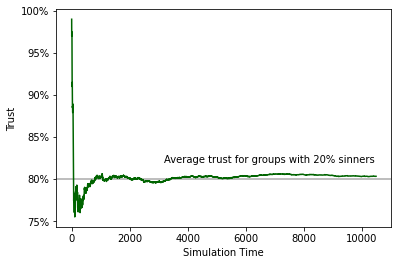

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100,0))
plt.ylabel("Trust")
plt.xlabel("Simulation Time")
plt.axhline(y=80, color="DarkGrey")
ax.plot(df.Time, df.Trust, color="DarkGreen")
plt.text(3200,82,'Average trust for groups with 20% sinners')
plt.show()

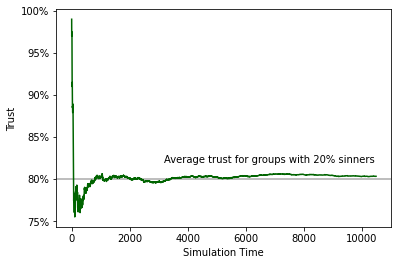

In [8]:
mpl.use('svg')
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100,0))
plt.ylabel("Trust")
plt.xlabel("Simulation Time")
plt.axhline(y=80, color="DarkGrey")
ax.plot(df.Time, df.Trust, color="DarkGreen")
plt.text(3200,82,'Average trust for groups with 20% sinners')
plt.savefig("TrustWithoutPunishment.svg", format="svg")

In [9]:
x = AgentBasedModel(320,0,80,0)
x.run(20500)
df = pd.DataFrame(x.data, columns=['Time', 'Trust', 'Sinners'])

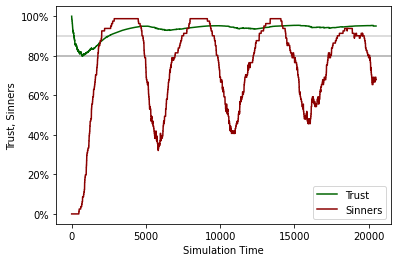

In [10]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100,0))
plt.ylabel("Trust, Sinners")
plt.xlabel("Simulation Time")
plt.axhline(y=80, color="DarkGrey")
plt.axhline(y=90, color="LightGrey")
ax.plot(df.Time, df.Trust, color="DarkGreen", label='Trust')
ax.plot(df.Time, df.Sinners, color="DarkRed", label='Sinners')
ax.legend()

plt.show()

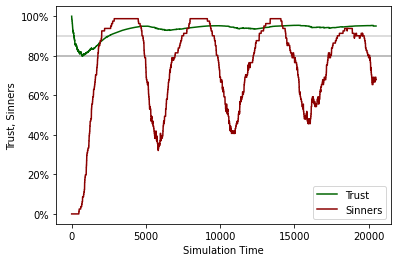

In [11]:
mpl.use('svg')
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100,0))
plt.ylabel("Trust, Sinners")
plt.xlabel("Simulation Time")
plt.axhline(y=80, color="DarkGrey")
plt.axhline(y=90, color="LightGrey")
ax.plot(df.Time, df.Trust, color="DarkGreen", label='Trust')
ax.plot(df.Time, df.Sinners, color="DarkRed", label='Sinners')
ax.legend()

plt.savefig("TrustWithPunishment.svg", format="svg")

In [12]:
x = AgentBasedModel(0,80,00,20)
x.run(10500)
df = pd.DataFrame(x.data, columns=['Time', 'Trust', 'Sinners'])
df.head(10)

,Time,Trust,Sinners
0,0,100.0,0
1,1,100.0,0
2,2,99.0,0
3,3,99.0,0
4,4,99.0,0
5,5,98.0,0
6,6,97.0,0
7,7,97.0,0
8,8,96.0,0
9,9,96.0,0


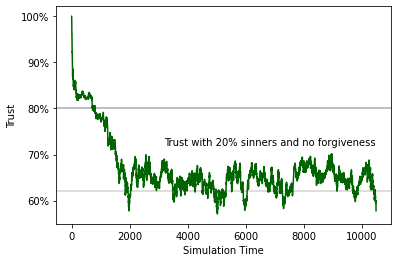

In [13]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100,0))
plt.ylabel("Trust")
plt.xlabel("Simulation Time")
plt.axhline(y=80, color="DarkGrey")
plt.axhline(y=62, color="LightGrey")
ax.plot(df.Time, df.Trust, color="DarkGreen", label='Trust')
plt.text(3200,72,'Trust with 20% sinners and no forgiveness')
plt.show()

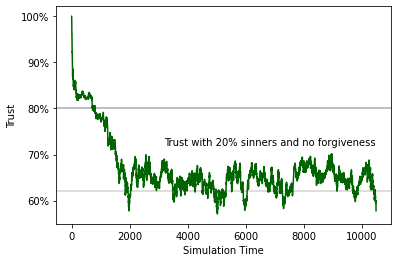

In [14]:
mpl.use('svg')
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100,0))
plt.ylabel("Trust")
plt.xlabel("Simulation Time")
plt.axhline(y=80, color="DarkGrey")
plt.axhline(y=62, color="LightGrey")
ax.plot(df.Time, df.Trust, color="DarkGreen", label='Trust')
plt.text(3200,72,'Trust with 20% sinners and no forgiveness')

plt.savefig("TrustWithoutForgiveness.svg", format="svg")